In [1]:
import os
import os.path
import random
import gc
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
sns.set()

In [5]:
import pickle

def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [6]:
DATA_DIR = '../input/open-problems-multimodal'
%ls $DATA_DIR -lh

total 27G
-rw-r--r-- 1 nobody nogroup 2.3G Sep  7 20:28 evaluation_ids.csv
-rw-r--r-- 1 nobody nogroup 9.4M Sep  7 20:28 metadata.csv
-rw-r--r-- 1 nobody nogroup 230K Sep  7 20:28 metadata_cite_day_2_donor_27678.csv
-rw-r--r-- 1 nobody nogroup 805M Sep  7 20:28 sample_submission.csv
-rw-r--r-- 1 nobody nogroup 1.6G Sep  7 20:28 test_cite_inputs.h5
-rw-r--r-- 1 nobody nogroup 294M Sep  7 20:28 test_cite_inputs_day_2_donor_27678.h5
-rw-r--r-- 1 nobody nogroup 6.1G Sep  7 20:29 test_multi_inputs.h5
-rw-r--r-- 1 nobody nogroup 2.4G Sep  7 20:29 train_cite_inputs.h5
-rw-r--r-- 1 nobody nogroup  37M Sep  7 20:28 train_cite_targets.h5
-rw-r--r-- 1 nobody nogroup  11G Sep  7 20:30 train_multi_inputs.h5
-rw-r--r-- 1 nobody nogroup 3.0G Sep  7 20:29 train_multi_targets.h5


## Read Data

In [7]:
%%time
train_inp = pd.read_hdf(f'{DATA_DIR}/train_cite_inputs.h5')
train_inp_cols = train_inp.columns

CPU times: user 18.4 s, sys: 3.75 s, total: 22.2 s
Wall time: 43.6 s


In [8]:
%%time
test_inp = pd.read_hdf(f'{DATA_DIR}/test_cite_inputs.h5')

CPU times: user 12.8 s, sys: 2.05 s, total: 14.8 s
Wall time: 30 s


In [9]:
%%time
train_tar = pd.read_hdf(f'{DATA_DIR}/train_cite_targets.h5')
train_tar_cols = train_tar.columns

CPU times: user 161 ms, sys: 42 ms, total: 203 ms
Wall time: 617 ms


## Data Preprocessing

Find columns with all zeroes

In [10]:
%%time
zero_cols = []
for idx, col in enumerate(train_inp_cols, 0):
    if idx % 1000 == 0:
        print(idx)
    if len(train_inp[col].unique()) == 1 or len(test_inp[col].unique()) == 1:
        zero_cols.append(col)
print('Number of columns with zero values only (Train or Test):', 
      len(zero_cols))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
Number of columns with zero values only (Train or Test): 1194
CPU times: user 31.8 s, sys: 140 ms, total: 31.9 s
Wall time: 31.9 s


In [11]:
%%time
train_inp = train_inp.drop(zero_cols, axis=1)
train_inp_cols = train_inp.columns
test_inp = test_inp.drop(zero_cols, axis=1)
train_inp.shape, test_inp.shape

CPU times: user 640 ms, sys: 881 ms, total: 1.52 s
Wall time: 1.51 s


((70988, 20856), (48663, 20856))

In [12]:
# %%time
# np.min(train_inp.min().unique()), np.max(train_inp.max().unique())

In [13]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [14]:
sc = StandardScaler()
train_inp = sc.fit_transform(train_inp)
test_inp = sc.transform(test_inp)

In [15]:
del sc
gc.collect()

42

In [16]:
%mkdir ../tmp

In [17]:
dump_pickle(test_inp, '../tmp/test_inp')
del test_inp
gc.collect()

42

In [18]:
train_tar = train_tar.values

## Modeling

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

In [20]:
# torch.manual_seed(42)
# torch.backends.cudnn.deterministic = True

In [21]:
%%time
train_inp = torch.from_numpy(train_inp)
train_tar = torch.from_numpy(train_tar)

CPU times: user 31 µs, sys: 0 ns, total: 31 µs
Wall time: 34.1 µs


In [22]:
full_ds = TensorDataset(train_inp, train_tar)
train_sz = 56800
val_sz = len(full_ds) - train_sz
train_ds, val_ds = random_split(full_ds, 
                                [train_sz, val_sz],
                                generator=torch.Generator().manual_seed(42))

In [23]:
batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [24]:
class Net(nn.Module):
    def __init__(self):
        """In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
        self.linear1 = nn.Linear(20856, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.linear3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.linear4 = nn.Linear(128, 140)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x

In [25]:
# preds = net(x)
# vpreds = preds - torch.mean(preds)
# vy = y - torch.mean(y)
# loss = torch.sum(vpreds * vy) / \
#        (torch.sqrt(torch.sum(vpreds ** 2)) *
#         torch.sqrt(torch.sum(vy ** 2)))
# loss

In [26]:
def train_model(train_loader, model, optimizer):
    
    model.train()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(train_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        total += batch
        sum_corr += batch * corr
    
    train_corr = sum_corr/total 
    return train_corr

In [27]:
def model_eval(model, val_loader):
    model.eval()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(val_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        total += batch
        sum_corr += batch * corr
        
    val_corr = sum_corr/total
    return val_corr

In [28]:
res = []
lrs = [0.01, 0.001, 0.0001, 0.00001]
wds = [0.1, 0.01]
epochs = 50

for learning_rate in lrs:
    for weight_decay in wds:
        print('------')
        print(f'learning rate: {learning_rate}')
        print(f'weight decay: {weight_decay}')
        print()
        
        net = Net()
        optimizer = optim.Adam(net.parameters(),
                    lr=learning_rate,
                    weight_decay=weight_decay)
        
        train_corrs = []
        val_corrs = []
        
        for epoch in range(epochs):
            # train
            print('epoch', epoch)
            train_corr = train_model(train_loader, net, optimizer)
            train_corr = float(train_corr.detach().numpy())
            train_corrs.append(train_corr)
            print(f'train corr: {train_corr:.4f}')

            # val
            val_corr = model_eval(net, val_loader)
            val_corr = float(val_corr.detach().numpy())
            val_corrs.append(val_corr)
            print(f'val corr: {val_corr:.4f}')
            print()
        
        res.append([train_corrs, val_corrs, 
                    learning_rate, weight_decay])   
        
del net, train_corrs, val_corrs
gc.collect()

------
learning rate: 0.01
weight decay: 0.1

epoch 0
train corr: 0.7900
val corr: 0.7983

epoch 1
train corr: 0.8095
val corr: 0.7853

epoch 2
train corr: 0.8003
val corr: 0.7655

epoch 3
train corr: 0.8017
val corr: 0.7966

epoch 4
train corr: 0.8062
val corr: 0.7968

epoch 5
train corr: 0.8075
val corr: 0.7714

epoch 6
train corr: 0.8016
val corr: 0.7856

epoch 7
train corr: 0.8078
val corr: 0.7331

epoch 8
train corr: 0.8051
val corr: 0.7977

epoch 9
train corr: 0.8027
val corr: 0.7906

epoch 10
train corr: 0.8062
val corr: 0.7998

epoch 11
train corr: 0.8144
val corr: 0.7965

epoch 12
train corr: 0.8029
val corr: 0.7956

epoch 13
train corr: 0.8037
val corr: 0.7626

epoch 14
train corr: 0.8022
val corr: 0.7711

epoch 15
train corr: 0.8028
val corr: 0.7798

epoch 16
train corr: 0.8027
val corr: 0.7939

epoch 17
train corr: 0.8036
val corr: 0.8054

epoch 18
train corr: 0.8065
val corr: 0.8032

epoch 19
train corr: 0.8021
val corr: 0.7997

epoch 20
train corr: 0.8061
val corr: 0.8096

0

------
learning rate: 0.01
weight decay: 0.1
best score on val set: 0.8096

------
learning rate: 0.01
weight decay: 0.01
best score on val set: 0.8602

------
learning rate: 0.001
weight decay: 0.1
best score on val set: 0.8722

------
learning rate: 0.001
weight decay: 0.01
best score on val set: 0.8856

------
learning rate: 0.0001
weight decay: 0.1
best score on val set: 0.8839

------
learning rate: 0.0001
weight decay: 0.01
best score on val set: 0.8744

------
learning rate: 1e-05
weight decay: 0.1
best score on val set: 0.8335

------
learning rate: 1e-05
weight decay: 0.01
best score on val set: 0.8434



240

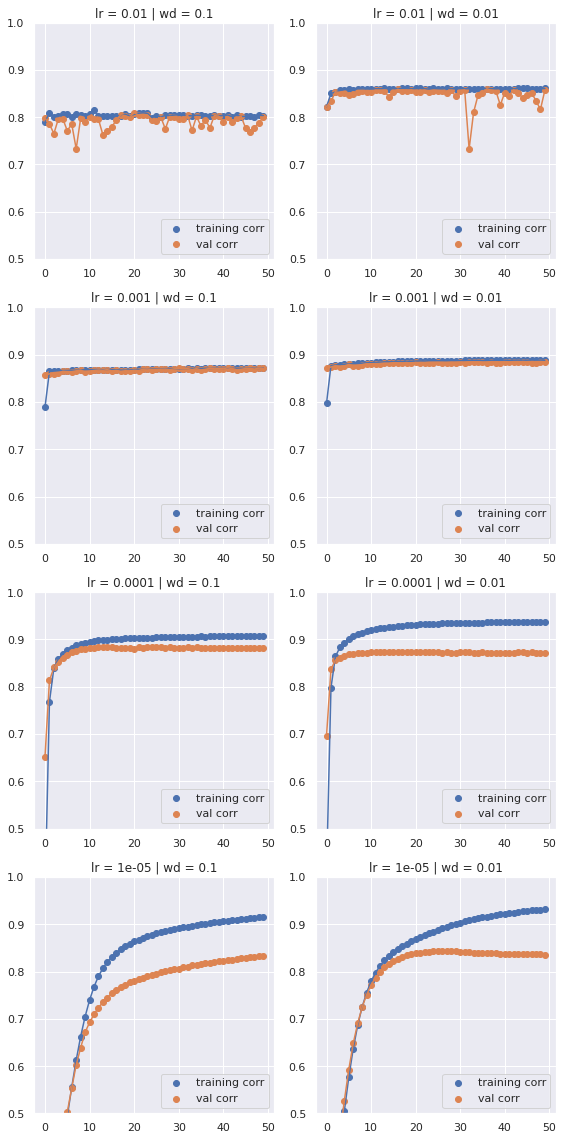

In [29]:
figsize(8, 16)
for i in range(8):
    train_corrs, val_corrs, learning_rate, weight_decay = res[i]
    print('------')
    print(f'learning rate: {learning_rate}')
    print(f'weight decay: {weight_decay}')
    print(f'best score on val set: {np.max(val_corrs):.4f}')
    print()
    
    plt.subplot(4, 2, i+1)
    plt.scatter(list(range(epochs)), 
                train_corrs, 
                label='training corr')
    plt.plot(list(range(epochs)), 
             train_corrs)
    plt.scatter(list(range(epochs)), 
                val_corrs, 
                label='val corr')
    plt.plot(list(range(epochs)), 
             val_corrs)
    plt.legend(loc='lower right')
    plt.title(f'lr = {learning_rate} | wd = {weight_decay}')
    plt.ylim(0.5, 1)
plt.tight_layout()

del train_corrs, val_corrs
gc.collect()

In [30]:
# net = Net()
# learning_rate = 0.001
# weight_decay = 0.01 
# optimizer = optim.Adam(net
#                        .parameters(),
#                        lr=learning_rate,
#                        weight_decay=weight_decay)

In [31]:
# %%time
# epochs = 100
# train_corrs = []
# val_corrs = []
# best_val_corr = 0.0
# best_epoch = 0

# for epoch in range(epochs):
#     # train
#     print('epoch', epoch)
#     train_corr = train_model(train_loader, net, optimizer)
#     train_corr = float(train_corr.detach().numpy())
#     train_corrs.append(train_corr)
#     print(f'train corr: {train_corr:.4f}')
    
#     # val
#     val_corr = model_eval(net, val_loader)
#     val_corr = float(val_corr.detach().numpy())
#     val_corrs.append(val_corr)
#     print(f'val corr: {val_corr:.4f}')
#     print()
    
#     # early stoppage
#     if epoch - best_epoch > 5:
#         if val_corr < best_val_corr:
#             print(f'**Early Stoppage** We are stopping at epoch {epoch}...')
#             print(f'Best epoch: epoch {best_epoch}')
#             print(f'Best val correlation: {val_corr: .4f}')
#             break
            
#     # update
#     if val_corr > best_val_corr:
#         best_val_corr = max([best_val_corr, val_corr])
#         best_epoch = epoch
# #         print(epoch, best_epoch, best_val_corr)
# #         print()

In [32]:
# figsize(8, 8)
# plt.scatter(list(range(epochs)), train_corrs, label='training corr')
# plt.plot(list(range(epochs)), train_corrs)
# plt.scatter(list(range(epochs)), val_corrs, label='val corr')
# plt.plot(list(range(epochs)), val_corrs)
# plt.legend(loc='lower right')
# plt.title(f'lr = {learning_rate} | wd = {weight_decay}')
# plt.ylim(0, 1)

In [33]:
# train_inp[:1]

In [34]:
# with torch.no_grad():
#     net.eval()
#     train_tar_preds = net(train_inp[:5]).detach().numpy().flatten()

In [35]:
# np.corrcoef(train_tar_preds, train_tar[:5].detach().numpy().flatten())

In [36]:
del train_inp, train_tar, full_ds
gc.collect()

25806

## Prediction

In [37]:
# %%time
# test_inp = load_pickle('../tmp/test_inp')
# test_inp = torch.from_numpy(test_inp)

In [38]:
# with torch.no_grad():
#     net.eval()
#     test_tar_preds = net(test_inp).detach().numpy()

In [39]:
# del test_inp
# gc.collect()

## Creating Submission

In [40]:
# DATA_DIR = '../input/msci-h5-sparse-transform'
# %ls $DATA_DIR -lh

In [41]:
# test_tar_cols = np.load(f'{DATA_DIR}/train_cite_targets_idx.npz',
#                         allow_pickle=True)['columns']
# test_tar_idx = np.load(f'{DATA_DIR}/test_cite_inputs_idx.npz',
#                        allow_pickle=True)['index']
# test_tar_cols.shape, test_tar_idx.shape, test_tar_preds.shape

In [42]:
# %%time
# print('Start Eval...')
# eval_ids = pd.read_parquet(f'{DATA_DIR}/evaluation_ids.parquet')
# eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
# eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

In [43]:
# %%time
# sub = pd.Series(name='target',
#                 index=pd.MultiIndex.from_frame(eval_ids), 
#                 dtype=np.float32)
# sub

In [44]:
# cell_id_dict = {cell_id: idx 
#                 for idx, cell_id in enumerate(test_tar_idx, 0)}
# gene_id_dict = {gene_id: idx 
#                 for idx, gene_id in enumerate(test_tar_cols, 0)}

In [45]:
# eid_cid_idx = eval_ids['cell_id']\
#               .apply(lambda x: cell_id_dict.get(x, -1))
# eid_gid_idx = eval_ids['gene_id']\
#               .apply(lambda x: gene_id_dict.get(x, -1))
# valid_cite_rows = (eid_cid_idx != -1) & (eid_gid_idx != -1)

In [46]:
# %%time
# sub.iloc[valid_cite_rows] = test_tar_preds\
#                              [eid_cid_idx[valid_cite_rows].to_numpy(),
#                               eid_gid_idx[valid_cite_rows].to_numpy()]

In [47]:
# del eval_ids, test_tar_idx, test_tar_cols
# del eid_cid_idx, eid_gid_idx, valid_cite_rows
# gc.collect() 

In [48]:
# sub = pd.DataFrame(sub).fillna(0).reset_index()
# sub.drop(['cell_id', 'gene_id'], axis=1)\
#    .to_csv('cite_sub.csv', index=False)

In [49]:
# sub.head()